# BÀI THỰC HÀNH 3: MẠNG NEURAL HỒI QUY CHO BÀI TOÁN PHÂN LOẠI VĂN BẢN VÀ GÁN NHÃN CHUỖI

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses.

Bộ dữ liệu sử dụng: [UIT-VSFC](https://drive.google.com/drive/folders/1rdcXNGt_3-QUvV8EtSvVsLMVeHmk6Yqk?usp=drive_link) và [PhoNERT](https://github.com/VinAIResearch/PhoNER_COVID19).

# Import libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# EDA

## BỘ DỮ LIỆU PhoNERT

1. Kiểm tra cấu trúc dữ liệu

* Tải và đọc các file train, test, dev.

* In 20 dòng đầu để xem cấu trúc dữ liệu BIO

In [62]:
def read_coll(path):
    sentences = []
    with open(path, "r", encoding="utf-8") as f:
        sent = []
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    sent = []
            else:
                token, tag = line.split()
                sent.append((token, tag))
        if sent:
            sentences.append(sent)
    return sentences

train = read_coll("data/PhoNERT/train_word.conll")
dev   = read_coll("data/PhoNERT/dev_word.conll")
test  = read_coll("data/PhoNERT/test_word.conll")

In [63]:
# Print first 20 samples from train set
for sent in train[:20]:
    print(sent)

[('Đồng_thời', 'O'), (',', 'O'), ('bệnh_viện', 'O'), ('tiếp_tục', 'O'), ('thực_hiện', 'O'), ('các', 'O'), ('biện_pháp', 'O'), ('phòng_chống', 'O'), ('dịch_bệnh', 'O'), ('COVID', 'O'), ('-', 'O'), ('19', 'O'), ('theo', 'O'), ('hướng_dẫn', 'O'), ('của', 'O'), ('Bộ', 'B-ORGANIZATION'), ('Y_tế', 'I-ORGANIZATION'), ('.', 'O')]
[('"', 'O'), ('Số', 'O'), ('bệnh_viện', 'O'), ('có_thể', 'O'), ('tiếp_nhận', 'O'), ('bệnh_nhân', 'O'), ('bị', 'O'), ('sốt', 'B-SYMPTOM_AND_DISEASE'), ('cao', 'I-SYMPTOM_AND_DISEASE'), ('và', 'O'), ('khó', 'B-SYMPTOM_AND_DISEASE'), ('thở', 'I-SYMPTOM_AND_DISEASE'), ('đang', 'O'), ('giảm', 'O'), ('dần', 'O'), ('"', 'O'), (',', 'O'), ('thông_cáo', 'O'), ('có', 'O'), ('đoạn', 'O'), (',', 'O'), ('cảnh_báo', 'O'), ('những', 'O'), ('bệnh_nhân', 'O'), ('này', 'O'), ('thay', 'O'), ('vào', 'O'), ('đó', 'O'), ('được', 'O'), ('chuyển', 'O'), ('tới', 'O'), ('các', 'O'), ('phòng_khám', 'O'), ('khẩn_cấp', 'O'), (',', 'O'), ('khiến', 'O'), ('những', 'O'), ('bệnh_nhân', 'O'), ('mắc', 

2. Thống kê số câu trong từng tập

* Số câu trong train/dev/test

* Số lượng token mỗi tập

In [64]:
# Sentences in datasets
print(f"Number of sentences in Train set: {len(train)}")
print(f"Number of sentences in Dev set: {len(dev)}")
print(f"Number of sentences in Test set: {len(test)}")

Number of sentences in Train set: 5027
Number of sentences in Dev set: 2000
Number of sentences in Test set: 3000


In [65]:
# Tokens in datasets
print (f"Number of tokens in Train set: {sum(len(s) for s in train)}")
print (f"Number of tokens in Dev set: {sum(len(s) for s in dev)}")
print (f"Number of tokens in Test set: {sum(len(s) for s in test)}")

Number of tokens in Train set: 132511
Number of tokens in Dev set: 56283
Number of tokens in Test set: 85678


3. Phân bố nhãn thực thể

* Thống kê số lần xuất hiện của từng nhãn (B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, O,...).

* Vẽ biểu đồ bar chart phân bố nhãn.

Trả lời:

* Nhãn nào xuất hiện nhiều nhất?

* Nhãn nào xuất hiện hiếm?

In [66]:
# Label distribution in dataset
def get_label_distribution(dataset):
    labels = []
    for sentence in dataset:
        for token, tag in sentence:
            labels.append(tag)
    return Counter(labels)

train_label_counts = get_label_distribution(train)
dev_label_counts = get_label_distribution(dev)
test_label_counts = get_label_distribution(test)

label_counts = pd.DataFrame({
    "Train": pd.Series(train_label_counts),
    "Dev": pd.Series(dev_label_counts),
    "Test": pd.Series(test_label_counts)
}).fillna(0).astype(int)
label_counts


,Train,Dev,Test
B-AGE,682,361,582
B-DATE,2549,1103,1654
B-GENDER,542,277,462
B-JOB,205,132,173
B-LOCATION,5398,2737,4441
B-NAME,349,188,318
B-ORGANIZATION,1137,551,771
B-PATIENT_ID,3240,1276,2005
B-SYMPTOM_AND_DISEASE,1439,766,1136
B-TRANSPORTATION,226,87,193


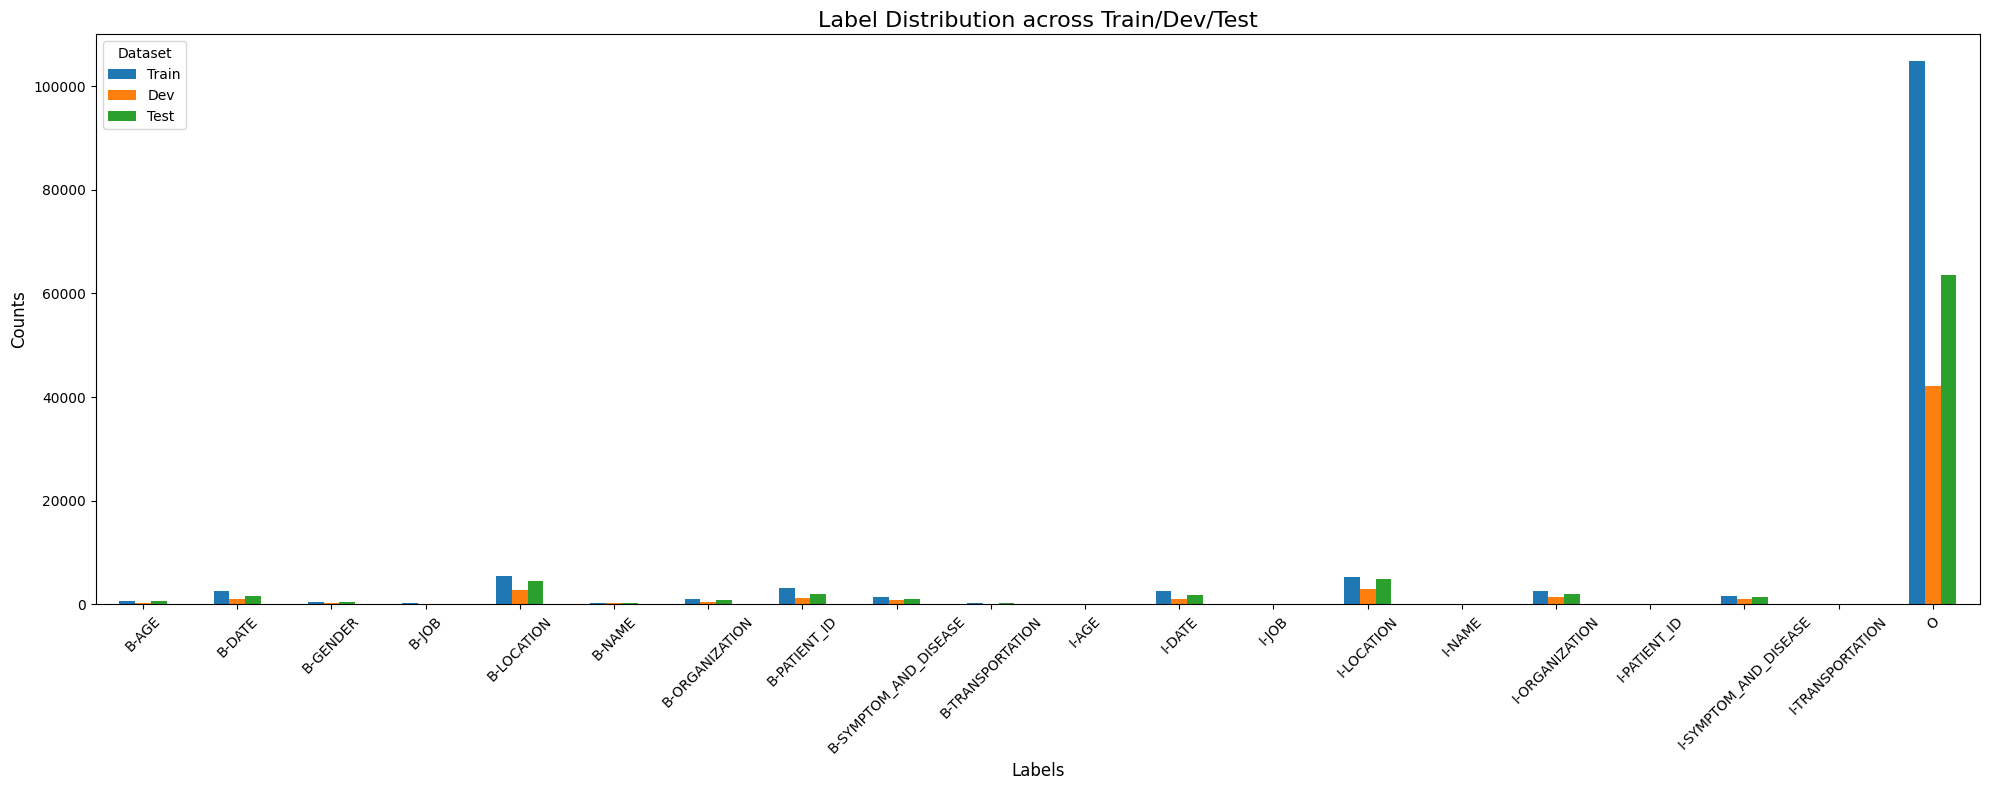

In [67]:
# Plot label distribution
label_counts.plot(kind="bar", figsize=(20,8))
plt.title("Label Distribution across Train/Dev/Test", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

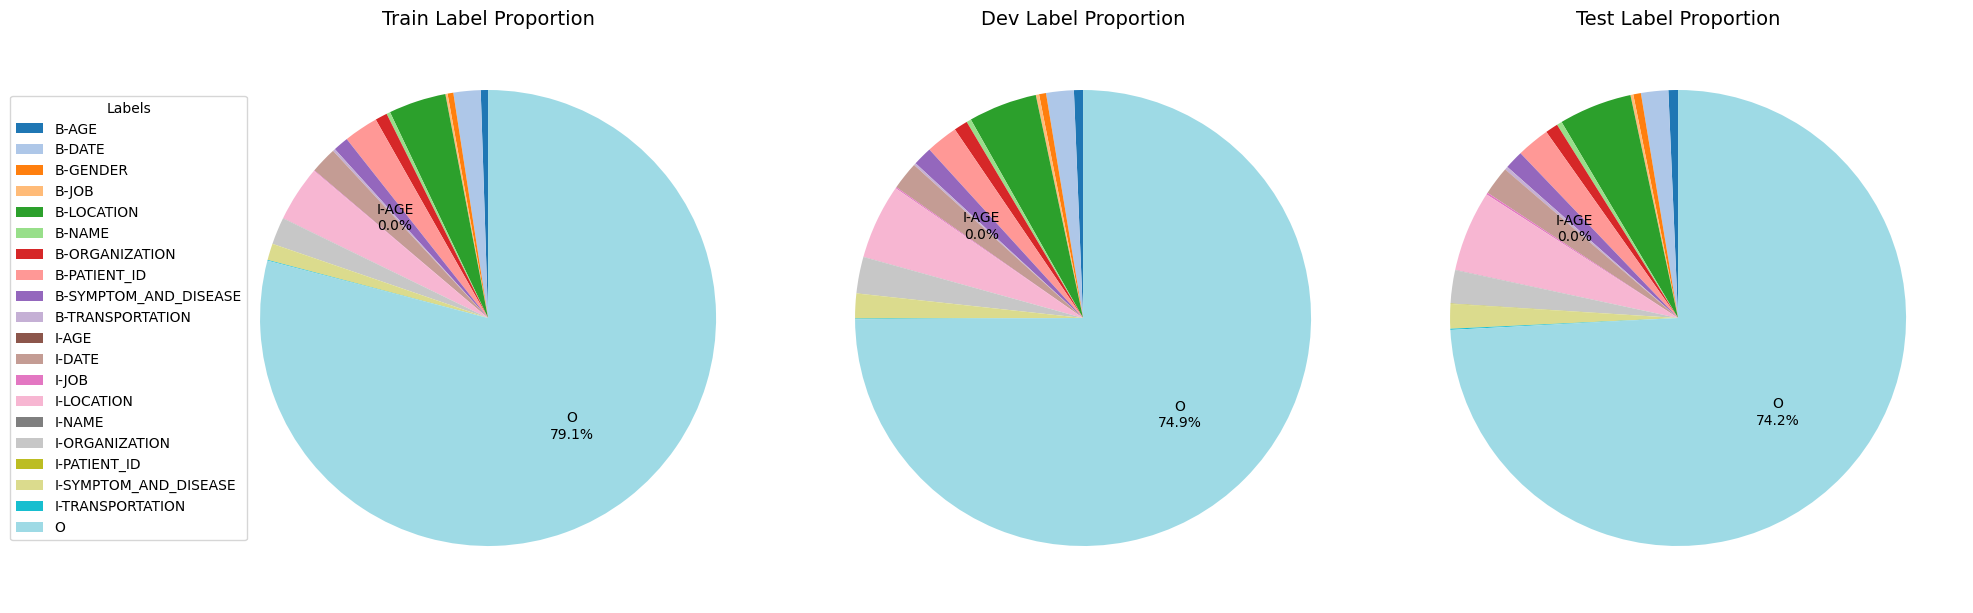

In [68]:
# Pie charts for label proportions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sets = ['Train', 'Dev', 'Test']
colors = plt.get_cmap("tab20").colors

for ax, set_name in zip(axes, sets):
    data = label_counts[set_name]

    max_label = data.idxmax()
    min_label = data.idxmin()

    def autopct_func(pct, allvals=data):
        total = sum(allvals)
        value = int(round(pct*total/100.0))
        if value == allvals[max_label] or value == allvals[min_label]:
            return f"{pct:.1f}%"
        else:
            return ""
        
    wedges, texts, autotexts = ax.pie(
        data,
        labels=None,
        autopct=autopct_func,
        colors=colors,
        startangle=90
    )

    for i, w in enumerate(wedges):
        label = data.index[i]
        if label in [max_label, min_label]:
            autotexts[i].set_text(f"{label}\n{autotexts[i].get_text()}")
        else:
            autotexts[i].set_text("")

    ax.set_title(f"{set_name} Label Proportion", fontsize=14)

fig.legend(
    wedges, label_counts.index,
    title="Labels",
    loc="center left",
    bbox_to_anchor=(-0.1, 0.5)
)

plt.tight_layout()
plt.show()


* Nhãn O xuất hiện nhiều nhất, chiếm trên 70% trên mỗi tập.
* Nhãn I-AGE xuất hiện ít nhất (ít hơn 10 lần) trên mỗi tập.

4. Phân tích độ dài câu

* Tính số token cho từng câu.

* Tìm min / max / mean.

Trả lời câu hỏi: padding tối ưu? có câu nào quá dài gây bất lợi cho LSTM?

In [69]:
def get_sentence_lengths(dataset):
    return [len(sentence) for sentence in dataset]

# Token in sentences
train_lengths = get_sentence_lengths(train)
dev_lengths   = get_sentence_lengths(dev)
test_lengths  = get_sentence_lengths(test)

print(f"Train sentences: {train_lengths}")
print(f"Dev sentences: {dev_lengths}")
print(f"Test sentences: {test_lengths}")

Train sentences: [18, 48, 27, 27, 24, 59, 45, 19, 15, 14, 17, 34, 28, 40, 40, 13, 27, 28, 13, 11, 20, 40, 40, 31, 22, 27, 13, 21, 17, 48, 38, 95, 25, 42, 23, 21, 43, 17, 13, 28, 33, 12, 46, 42, 33, 45, 24, 18, 25, 31, 21, 13, 14, 60, 30, 16, 28, 40, 34, 32, 26, 19, 17, 35, 16, 25, 27, 16, 67, 13, 13, 18, 40, 17, 27, 24, 9, 14, 52, 27, 12, 61, 13, 30, 26, 25, 29, 49, 30, 29, 14, 22, 17, 9, 17, 12, 24, 9, 41, 27, 13, 17, 25, 25, 29, 17, 26, 22, 34, 30, 16, 41, 15, 31, 34, 23, 12, 52, 18, 39, 14, 25, 7, 24, 21, 30, 24, 40, 28, 22, 16, 27, 22, 13, 25, 33, 20, 21, 31, 34, 19, 15, 40, 24, 18, 25, 48, 29, 23, 18, 20, 19, 28, 31, 25, 20, 37, 20, 31, 18, 16, 8, 21, 26, 24, 18, 16, 11, 29, 32, 73, 34, 25, 13, 18, 22, 18, 35, 19, 24, 35, 15, 22, 40, 12, 36, 23, 18, 25, 25, 42, 26, 21, 10, 14, 21, 22, 56, 25, 28, 18, 43, 38, 22, 34, 41, 15, 21, 16, 25, 41, 25, 18, 12, 48, 9, 56, 35, 15, 35, 14, 18, 22, 16, 15, 42, 23, 31, 19, 11, 22, 28, 23, 16, 15, 47, 15, 23, 22, 34, 35, 26, 43, 24, 18, 9, 41, 1

In [70]:
# Min / Max / Mean sentence lengths
print("Train:")
print("  Min:", np.min(train_lengths))
print("  Max:", np.max(train_lengths))
print("  Mean:", np.mean(train_lengths))

print("Dev:")
print("  Min:", np.min(dev_lengths))
print("  Max:", np.max(dev_lengths))
print("  Mean:", np.mean(dev_lengths))

print("Test:")
print("  Min:", np.min(test_lengths))
print("  Max:", np.max(test_lengths))
print("  Mean:", np.mean(test_lengths))


Train:
  Min: 6
  Max: 161
  Mean: 26.359856773423513
Dev:
  Min: 7
  Max: 138
  Mean: 28.1415
Test:
  Min: 7
  Max: 162
  Mean: 28.559333333333335


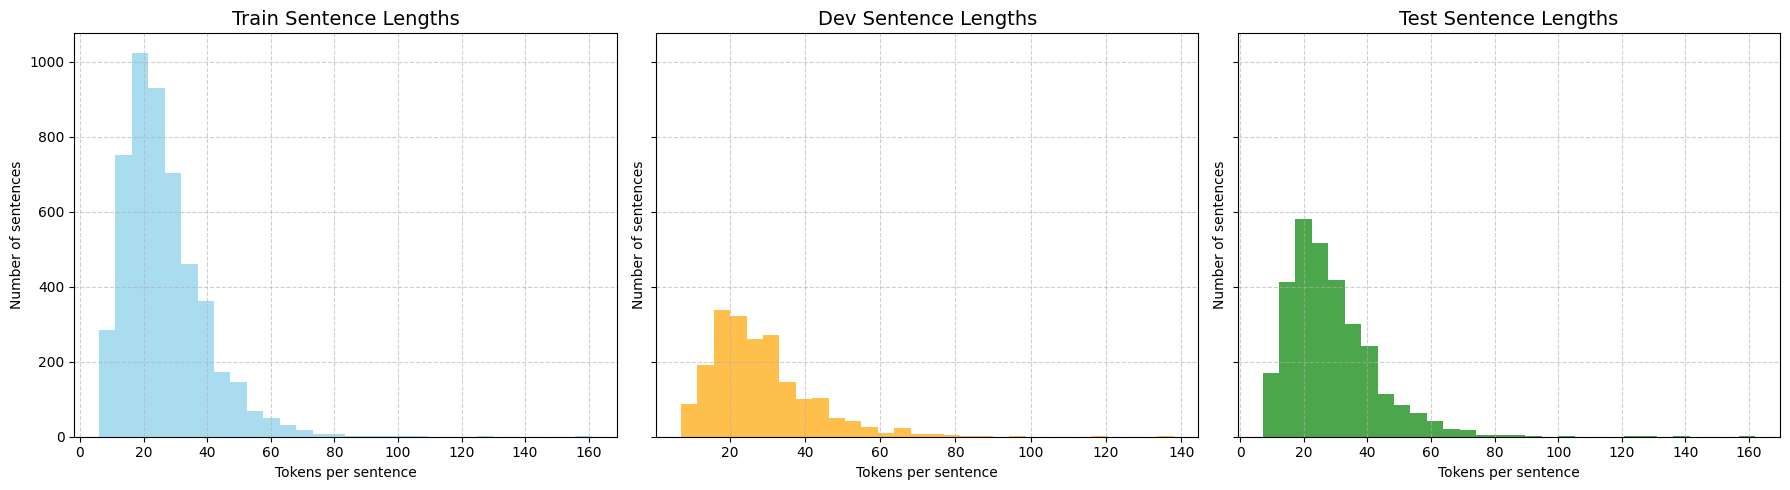

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
datasets = [train_lengths, dev_lengths, test_lengths]
titles = ["Train", "Dev", "Test"]
colors = ["skyblue", "orange", "green"]

for ax, data, title, color in zip(axes, datasets, titles, colors):
    ax.hist(data, bins=30, color=color, alpha=0.7)
    ax.set_title(f"{title} Sentence Lengths", fontsize=14)
    ax.set_xlabel("Tokens per sentence")
    ax.set_ylabel("Number of sentences")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


In [72]:
optimal_pad = int(np.percentile(train_lengths, 95))
print("Padding (95%):", optimal_pad)

Padding (95%): 50


* Biểu đồ histogram cho thấy phần lớn câu nằm trong khoảng 10–40 tokens, đỉnh khoảng 20 và gần như toàn bộ tập dữ liệu (khoảng 95%) có độ dài không quá 50 token; do đó chọn MAX_LEN = 50 giúp mô hình huấn luyện nhanh hơn và tiết kiệm bộ nhớ.

* Trong dữ liệu vẫn tồn tại một số câu rất dài (trên 100 token, tối đa tới 161–162) và khi chọn padding = 50 thì những câu này sẽ bị cắt bớt. Vì những outliers này  chiếm tỷ lệ rất nhỏ so với toàn bộ tập, nên việc cắt bớt không ảnh hưởng nhiều đến mô hình.

### Bài 3: Xây dựng kiến trúc Encoder trong đó Encoder gồm 5 lớp BiLSTM với hidden size là 256 cho bài toán nhận diện thực thể (Name Entity Recognition). Huấn luyện mô hình trên bộ dữ liệu PhoNER và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Define hyperparameters
VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
MAX_LEN = 50
HIDDEN_SIZE = 256
DROPOUT_RATE = 0.3
NUM_CLASSES = 20
EPOCHS = 5
BATCH_SIZE = 32

In [74]:
# Prepare data
train_tokens = [[tok for tok, tag in sent] for sent in train]
train_tags   = [[tag for tok, tag in sent] for sent in train]

dev_tokens = [[tok for tok, tag in sent] for sent in dev]
dev_tags   = [[tag for tok, tag in sent] for sent in dev]

test_tokens = [[tok for tok, tag in sent] for sent in test]
test_tags   = [[tag for tok, tag in sent] for sent in test]

# Tokenizer
tokenizer = Tokenizer(lower=False, oov_token="<UNK>")
tokenizer.fit_on_texts(train_tokens)

# Padding sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_tokens), maxlen=MAX_LEN, padding="post")
X_dev   = pad_sequences(tokenizer.texts_to_sequences(dev_tokens), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_tokens), maxlen=MAX_LEN, padding="post")

In [75]:
# Encode tags
le = LabelEncoder()
tags = [tag for sent in train_tags for tag in sent]
tags.append("PAD")
le.fit(tags)
PAD_ID = le.transform(["PAD"])[0]

# Transform tags to sequences of integers
y_train = pad_sequences([le.transform(sent) for sent in train_tags], maxlen=MAX_LEN, padding="post", value=le.transform(["O"])[0])
y_dev   = pad_sequences([le.transform(sent) for sent in dev_tags],   maxlen=MAX_LEN, padding="post", value=le.transform(["O"])[0])
y_test  = pad_sequences([le.transform(sent) for sent in test_tags],  maxlen=MAX_LEN, padding="post", value=le.transform(["O"])[0])

In [76]:
model = Sequential([
    # Layer 1: Embedding
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=EMBEDDING_DIM, 
              input_length=MAX_LEN,
              mask_zero=True,
              name='Embedding_Layer'),
    
    # 5 layers BiLSTM
    Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE), name='BiLSTM_Layer_1'),
    Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE), name='BiLSTM_Layer_2'),
    Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE), name='BiLSTM_Layer_3'),
    Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE), name='BiLSTM_Layer_4'),
    Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True, dropout=DROPOUT_RATE), name='BiLSTM_Layer_5'),
    
    # Output layer
    Dense(NUM_CLASSES, activation='softmax', name='Output_Layer')
])

model.summary()


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Layer_1 (Bidirectional)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Layer_2 (Bidirectional)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Layer_3 (Bidirectional)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Layer_4 (Bidirectional)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_Layer_5 (Bidirectional)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, pad_id, average="macro"):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.pad_id = pad_id
        self.average = average
        self.best_f1 = 0.0

    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=-1)
        y_true = self.y_val

        mask = (y_true != self.pad_id)
        y_true_flat = y_true[mask]
        y_pred_flat = y_pred[mask]

        f1 = f1_score(y_true_flat, y_pred_flat, average=self.average)
        logs["val_f1_score"] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.model.save("best_phonert.keras")


In [78]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Initialize F1 Score Callback
f1_callback = F1ScoreCallback(validation_data=(X_dev, y_dev), pad_id=PAD_ID, average="macro")

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[f1_callback],
    verbose=1
)


Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.8863 - loss: 0.9919 - val_accuracy: 0.8707 - val_loss: 0.8563 - val_f1_score: 0.0979
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.9214 - loss: 0.5451 - val_accuracy: 0.9355 - val_loss: 0.4236 - val_f1_score: 0.3900
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9700 - loss: 0.2125 - val_accuracy: 0.9630 - val_loss: 0.2717 - val_f1_score: 0.5354
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.9828 - loss: 0.1191 - val_accuracy: 0.9670 - val_loss: 0.2413 - val_f1_score: 0.5771
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9872 - loss: 0.0850 - val_accuracy: 0.9702 - val_loss: 0.2292 - val_f1_score: 0.6407


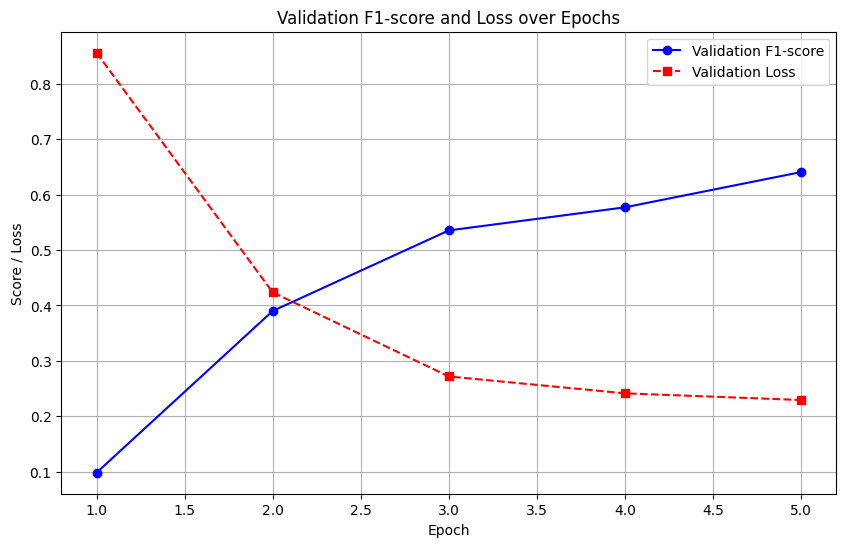

In [79]:
# Plot F1-score and Loss over epochs
f1_scores = history.history['val_f1_score']
val_losses = history.history['val_loss']
epochs = range(1, len(f1_scores) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b', label='Validation F1-score')
plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label='Validation Loss')
plt.title('Validation F1-score and Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score / Loss')
plt.legend()
plt.grid(True)
plt.show()


* Validation F1-score (xanh): Tăng đều từ khoảng 0.1 lên đến 0.65 sau 5 epoch, cho thấy mô hình ngày càng phân loại tốt hơn.

* Validation Loss (đỏ): Giảm rõ rệt từ khoảng 0.85 xuống còn 0.2, chứng tỏ mô hình đang học đúng hướng, không bị overfitting trong giai đoạn đầu.

-> Biểu đồ cho thấy mô hình đang học ổn định với F1-score tăng đều và loss giảm rõ rệt qua từng epoch, chưa có dấu hiệu overfitting trên 5 epochs. Có thể tiếp tục huấn luyện thêm với 10-20 epochs, khi đó nên áp dụng EarlyStopping để dừng khi F1 không cải thiện, dùng ReduceLROnPlateau nếu loss chững lại, hoặc điều chỉnh batch size và dropout để kiểm soát overfitting.


In [80]:
# Load the best model
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=-1)
y_true = y_test

# Calculate F1-score on test set
mask = (y_true != PAD_ID)
y_true_flat = y_true[mask]
y_pred_flat = y_pred[mask]

# Print classification report
print("F1-score:", f1_score(y_true_flat, y_pred_flat, average="macro"))

labels = [i for i in range(len(le.classes_)) if i != PAD_ID]
target_names = [tag for i, tag in enumerate(le.classes_) if i != PAD_ID]
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=target_names))

94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 558ms/step
F1-score: 0.5954585232913995
                       precision    recall  f1-score   support

                B-AGE       0.88      0.94      0.91       551
               B-DATE       0.96      0.96      0.96      1582
             B-GENDER       0.93      0.85      0.89       427
                B-JOB       1.00      0.01      0.02       169
           B-LOCATION       0.92      0.84      0.88      4354
               B-NAME       0.63      0.32      0.42       309
       B-ORGANIZATION       0.80      0.78      0.79       715
         B-PATIENT_ID       0.95      0.84      0.89      1930
B-SYMPTOM_AND_DISEASE       0.89      0.80      0.84      1128
     B-TRANSPORTATION       0.70      0.52      0.59       190
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.96      0.98      0.97      1639
                I-JOB       0.00      0.00      0.00       114
           I-LOCATION       0.94      0.78    

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Các nhãn phổ biến như B-DATE, B-AGE, B-GENDER, B-LOCATION, B-PATIENT_ID, O, B-ORGANIZATION, B-SYMPTOM_AND_DISEASE, I-DATE, I-JOB, I-LOCATION, I-ORGANIZATION, I-SYMPTOM_AND_DISEASE có F1 cao (trên 0.75), chứng tỏ mô hình học tốt với các thực thể rõ ràng và có nhiều mẫu.

* Nhãn I-JOB, I-PATIENT_ID, I-AGE có F1 = 0, cho thấy mô hình gần như không học được các thực thể này, do số lượng mẫu quá ít chỉ từ 6 đến 23 mẫu.

* Nhãn B-JOB có F1 ~ 0, cho thấy mô hình gần như không học được các thực thể này, do mô hình ưu tiên học các nhãn phổ biến hơn, hoặc nhãn không rõ ràng.

* Nhãn B-NAME có F1 = 0.42, cho thấy mô hình gặp khó khăn trong việc nhận diện tên riêng, có thể do tên đa dạng hoặc dễ nhầm lẫn với từ thông thường.

* Nhãn B-TRANSPORTATION có F1 = 0.59, recal thấp chỉ đạt 0.52, cho thấy mô hình bỏ sót một số thực thể dạng này.

* Nhãn I-TRANSPORTATION có F1 = 0.31, recall rất thấp (0.19), cho thấy mô hình bỏ sót nhiều thực thể dạng này.

F1-score trung bình đạt ~ 0.60 (macro) -> mô hình có khả năng nhận diện tương đối tốt các thực thể, nhưng vẫn cần cải thiện thêm như: Tăng dữ liệu huấn luyện cho các nhãn yếu, xử lý mất cân bằng nhãn bằng cách dùng class_weights hoặc sample_weights.